# CS145: Project 2 | KNN Baseline (25 points)
---
In this notebook, you'll be implementing a K-nearest neighbors baseline for predicting test datapoints using the closest training datapoints. This notebook will provide detailed instructions on the algorithm and challenge you to implement this using SQL.

Notes (read carefully!):
* Be sure you read the instructions on each cell and understand what it is doing before running it.
* Don't forget that if you can always re-download the starter notebook from the course website if you need to.
* You may create new cells to use for testing, debugging, exploring, etc., and this is in fact encouraged! Just make sure that the final answer for each question is **in its own cell** and **clearly indicated**.
* Colab will not warn you about how many bytes your SQL query will consume.  **Be sure to check on the BigQuery UI first before running queries here!**
* This project may be done alone or in pairs.
* See the assignment handout for submission instructions.
* The due date is **11:59 PM on December 1st, 2024** Note that the first portion of the assignment is still due on November 21st

## Setting Up BigQuery and Dependencies

Run the cells below (shift + enter) to authenticate your project.

Note that you need to fill in the `project_id` variable with the Google Cloud project id you are using for this course.  You can see your project ID by going to https://console.cloud.google.com/cloud-resource-manager

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-fall2024-project2"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

## Section 1: Constructing a KNN Baseline

In this notebook, you will be required to construct a database-only baseline (not linear or logistic regression). We recommend that you implement the $k$-nearest neighbours (KNN) algorithm for regression or classification using SQL.

Below, we have shown code for KNN in Python to demonstrate the algorithm (**note: you must use SQL later for credit, not Python!**).

In [ ]:
# Feel free to try out the KNN and change the parameters below!
# What happens when you increase k? How about the dataset size?
# What if k = 1?

import numpy as np
from statistics import mode

np.random.seed(42)

dataset_size, num_features = 100000, 2
k = 10
classify = False

def generate_fake_data(f, classify = True, noise = 1e-2):
    X = np.random.normal(0, 1, size = (dataset_size, num_features))
    y = f(X) + np.random.normal(0, noise, size = (dataset_size, ))
    if classify:
        y = np.sign(y)
    return X, y

def find_closest_k(X, x_t):
    distances = []
    for x_i in X:
        distances.append(np.linalg.norm(x_t - x_i))
    return np.argsort(distances)[:k]

def select_target_value(Y, k_idx, classify = True):
    if classify:
        return mode(Y[k_idx])
    return np.mean(Y[k_idx])

def initialize_knn(X, Y, classify = True):
    def predict(x_t):
        k_idx = find_closest_k(X, x_t)
        return select_target_value(Y, k_idx, classify)
    return predict

def true_prediction_error(f, x_t, y_hat):
    return np.abs(f(x_t) - y_hat)

theta = np.random.uniform(size = (num_features, ))
f = lambda x: x @ theta
X, Y = generate_fake_data(f, classify = classify)
knn = initialize_knn(X, Y, classify = classify)

# Making a prediction on a data point.
print("Prediction on 1st data point:", knn(X[0]))
print("Actual target for 1st data point:", Y[0], "\n")

# Making a prediction on an unseen (test) data point.
x_t = np.random.normal(0, 1, (num_features, ))
print("Prediction on test data point:", knn(x_t))
if classify:
    print("Actual target for test data point:", np.sign(f(x_t)))
else:
    print("Actual target for test data point:", f(x_t))

Prediction on 1st data point: 1.6899609961913993
Actual target for 1st data point: 1.6772562596324967 

Prediction on test data point: -0.31655056190335984
Actual target for test data point: -0.31453323837938046


Read through the code above and make sure you understand the algorithm. The general idea behind KNN is that we save our training data into memory, then for each datapoint in the test set, we find the K closest training data points, and take an aggregation (a mean for regression or the mode for classification) of those $y$ values to predict the $y$ value for the test datapoint. This is a simple unsupervised learning algorithm that provides a baseline for more complex linear regression and logistic regression methods.

## Section 2: Implementing KNN using SQL (10 points)

Now it's your turn! Implement the KNN logic using SQL. You can set K to different values depending on what has the best performance, and instead of generating fake data, you should use your data from Project 2 -- so use the same training data and test data you used for the machine learning models in Project 2.

Your query should output the mean squared error and R-squared values of the KNN algorithm on your data. As a challenge, find the K that minimizes your mean squared error!

## Prepping the data and running KNN


In [ ]:
%%bigquery --project $project_id
-- Augment this value for desired K
-- Replace `k` directly in the WHERE clause for BigQuery queries


CREATE OR REPLACE TABLE `cs145-fall2024-project2.crime_prediction_model.KNN_predictions` AS

-- CTEs for Training and Test Data
WITH training AS (
  SELECT
    ROW_NUMBER() OVER (ORDER BY year ASC) AS id,
    zip_code,
    year,
    crime_count, -- TARGET
    median_age,
    bachelors_degree,
    high_school_diploma,
    employed_education_health_social,
    employed_finance_insurance_real_estate,
    employed_information,
    occupation_management_arts,
    occupation_sales_office,
    management_business_sci_arts_employed,
    sales_office_employed,
    lag_crime_count
  FROM
    `cs145-fall2024-project2.crime_prediction_model.aggregated_crime_with_lags`
  WHERE
    year BETWEEN 2011 AND 2016
),
test AS (
  SELECT
    ROW_NUMBER() OVER (ORDER BY year ASC) AS id,
    zip_code,
    year,
    median_age,
    bachelors_degree,
    high_school_diploma,
    employed_education_health_social,
    employed_finance_insurance_real_estate,
    employed_information,
    occupation_management_arts,
    occupation_sales_office,
    management_business_sci_arts_employed,
    sales_office_employed,
    lag_crime_count
  FROM
    `cs145-fall2024-project2.crime_prediction_model.aggregated_crime_with_lags`
  WHERE
    year BETWEEN 2017 AND 2018
),

-- CTE to Calculate Feature Statistics
feature_stats AS (
  SELECT
    AVG(median_age) AS median_age_mean,
    STDDEV(median_age) AS median_age_std,
    AVG(bachelors_degree) AS bachelors_degree_mean,
    STDDEV(bachelors_degree) AS bachelors_degree_std,
    AVG(high_school_diploma) AS high_school_diploma_mean,
    STDDEV(high_school_diploma) AS high_school_diploma_std,
    AVG(employed_education_health_social) AS employed_education_health_social_mean,
    STDDEV(employed_education_health_social) AS employed_education_health_social_std,
    AVG(employed_finance_insurance_real_estate) AS employed_finance_insurance_real_estate_mean,
    STDDEV(employed_finance_insurance_real_estate) AS employed_finance_insurance_real_estate_std,
    AVG(employed_information) AS employed_information_mean,
    STDDEV(employed_information) AS employed_information_std,
    AVG(occupation_management_arts) AS occupation_management_arts_mean,
    STDDEV(occupation_management_arts) AS occupation_management_arts_std,
    AVG(occupation_sales_office) AS occupation_sales_office_mean,
    STDDEV(occupation_sales_office) AS occupation_sales_office_std,
    AVG(management_business_sci_arts_employed) AS management_business_sci_arts_employed_mean,
    STDDEV(management_business_sci_arts_employed) AS management_business_sci_arts_employed_std,
    AVG(sales_office_employed) AS sales_office_employed_mean,
    STDDEV(sales_office_employed) AS sales_office_employed_std,
    AVG(lag_crime_count) AS lag_crime_count_mean,
    STDDEV(lag_crime_count) AS lag_crime_count_std
  FROM
    `cs145-fall2024-project2.crime_prediction_model.aggregated_crime_with_lags`
),

-- Normalize the Data
normalized_training AS (
  SELECT
    id,
    zip_code,
    year,
    crime_count,
    (median_age - fs.median_age_mean) / fs.median_age_std AS median_age,
    (bachelors_degree - fs.bachelors_degree_mean) / fs.bachelors_degree_std AS bachelors_degree,
    (high_school_diploma - fs.high_school_diploma_mean) / fs.high_school_diploma_std AS high_school_diploma,
    (employed_education_health_social - fs.employed_education_health_social_mean) / fs.employed_education_health_social_std AS employed_education_health_social,
    (employed_finance_insurance_real_estate - fs.employed_finance_insurance_real_estate_mean) / fs.employed_finance_insurance_real_estate_std AS employed_finance_insurance_real_estate,
    (employed_information - fs.employed_information_mean) / fs.employed_information_std AS employed_information,
    (occupation_management_arts - fs.occupation_management_arts_mean) / fs.occupation_management_arts_std AS occupation_management_arts,
    (occupation_sales_office - fs.occupation_sales_office_mean) / fs.occupation_sales_office_std AS occupation_sales_office,
    (management_business_sci_arts_employed - fs.management_business_sci_arts_employed_mean) / fs.management_business_sci_arts_employed_std AS management_business_sci_arts_employed,
    (sales_office_employed - fs.sales_office_employed_mean) / fs.sales_office_employed_std AS sales_office_employed,
    (lag_crime_count - fs.lag_crime_count_mean) / fs.lag_crime_count_std AS lag_crime_count
  FROM training
  CROSS JOIN feature_stats fs
),
normalized_test AS (
  SELECT
    id,
    zip_code,
    year,
    (median_age - fs.median_age_mean) / fs.median_age_std AS median_age,
    (bachelors_degree - fs.bachelors_degree_mean) / fs.bachelors_degree_std AS bachelors_degree,
    (high_school_diploma - fs.high_school_diploma_mean) / fs.high_school_diploma_std AS high_school_diploma,
    (employed_education_health_social - fs.employed_education_health_social_mean) / fs.employed_education_health_social_std AS employed_education_health_social,
    (employed_finance_insurance_real_estate - fs.employed_finance_insurance_real_estate_mean) / fs.employed_finance_insurance_real_estate_std AS employed_finance_insurance_real_estate,
    (employed_information - fs.employed_information_mean) / fs.employed_information_std AS employed_information,
    (occupation_management_arts - fs.occupation_management_arts_mean) / fs.occupation_management_arts_std AS occupation_management_arts,
    (occupation_sales_office - fs.occupation_sales_office_mean) / fs.occupation_sales_office_std AS occupation_sales_office,
    (management_business_sci_arts_employed - fs.management_business_sci_arts_employed_mean) / fs.management_business_sci_arts_employed_std AS management_business_sci_arts_employed,
    (sales_office_employed - fs.sales_office_employed_mean) / fs.sales_office_employed_std AS sales_office_employed,
    (lag_crime_count - fs.lag_crime_count_mean) / fs.lag_crime_count_std AS lag_crime_count
  FROM test
  CROSS JOIN feature_stats fs
),

-- Compute Distances
distances AS (
  SELECT
    test.id as test_id,
    test.zip_code AS test_zip,
    training.zip_code AS train_zip,
    training.crime_count AS train_crime_count,
    SQRT(
      POWER(test.median_age - training.median_age, 2) +
      POWER(test.bachelors_degree - training.bachelors_degree, 2) +
      POWER(test.high_school_diploma - training.high_school_diploma, 2) +
      POWER(test.employed_education_health_social - training.employed_education_health_social, 2) +
      POWER(test.employed_finance_insurance_real_estate - training.employed_finance_insurance_real_estate, 2) +
      POWER(test.employed_information - training.employed_information, 2) +
      POWER(test.occupation_management_arts - training.occupation_management_arts, 2) +
      POWER(test.occupation_sales_office - training.occupation_sales_office, 2) +
      POWER(test.management_business_sci_arts_employed - training.management_business_sci_arts_employed, 2) +
      POWER(test.sales_office_employed - training.sales_office_employed, 2) +
      POWER(test.lag_crime_count - training.lag_crime_count, 2)
    ) AS distance
  FROM normalized_test AS test
  CROSS JOIN normalized_training AS training
),

-- Rank Neighbors
ranked_distances AS (
  SELECT
    test_id,
    test_zip,
    train_zip,
    train_crime_count,
    distance,
    ROW_NUMBER() OVER (
      PARTITION BY test_id
      ORDER BY distance ASC
    ) AS rank
  FROM distances
),

predictions AS (
  SELECT
    test_id,
    AVG(train_crime_count) AS predicted_crime_count
  FROM ranked_distances
  WHERE rank <= 2 -- k value
  GROUP BY test_id
)

SELECT *
FROM predictions;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

SELECT *
FROM `cs145-fall2024-project2.crime_prediction_model.KNN_predictions`;

Query is running:   0%|          |

Downloading:   0%|          |

,test_id,predicted_crime_count
0,50,1408.0
1,34,3968.5
2,82,3968.5
3,12,6662.0
4,60,6662.0
...,...,...
91,30,5535.5
92,27,10861.5
93,79,8315.5
94,31,8315.5


In [ ]:
%%bigquery --project $project_id

## Calculating the MSE

With test AS (
  SELECT
    ROW_NUMBER() OVER (ORDER BY year ASC) AS id,
    crime_count AS true_crime_count
  FROM
    `cs145-fall2024-project2.crime_prediction_model.aggregated_crime_with_lags`
  WHERE
    year = 2018
),
combined_table AS (
  SELECT
    test.id AS test_id,
    test.true_crime_count,
    predictions.predicted_crime_count
  FROM
    test
  JOIN
    `cs145-fall2024-project2.crime_prediction_model.KNN_predictions` AS predictions
  ON
    test.id = predictions.test_id
)
SELECT AVG(POWER(true_crime_count - predicted_crime_count, 2)) AS mse
FROM combined_table;

Query is running:   0%|          |

Downloading:   0%|          |

,mse
0,293594.572917


Describe your implementation below -- what were some of the challenges you faced? What kinds of intermediate SQL techniques did you use i.e. CTE's, subqueries, etc.

**To implement the functionality that exists in Pandas for Euclidean distances (one of the many ways to calculate distance for KNN), I had take steps to prep and sort the data as well as select the features for distance correctly. For instance, given that zip_code is a string that appears numeric, the first assumption would be to calculate the distance of zip_codes to other zip_codes, however, this would not work given that zip_codes is categorical and not numerical data. As such I selected and prepped the numerical data. Additionally, I added ID for each of the rows to have an identifier to distinguish the various data points. I had to do this since I excluded such information in my data aggregation from Project 2 and need an identifier to enable me to compare prediction based on the test data features to the true values in the test data.**

**After going through this procedure, I created a CTE with calculated MEAN and STDDEV for all of the numerical features for future use to find the standardized values of each of the features. With the MEAN and STDDEV, I normalized the training and test data to ensure that no feature with an obsurdly large scale had significantly more weight that other features. In other words, I ensure all features had equal weigh when calculating distances between the features of various data points by normalizing the data.**

**Moving on, I used the normalizations of the training and test data to calculate the euclidean distances between their numerical features. Following this, I ranked the neighbors of each data point and ordered the rankings by distance. I then used these rankings sorted by distance to find K-Nearest Neighbors and calcuated by predicted crime counts by taking the average of the neighbors of each data point. The calls to the ranked_distances and predictions CTE can be thought of as a double loop with ranked distances as the inner loop finding KNN neighbors and predictions as the outer loop that finds the average of KNN.**

**The final call, "SELECT {star} FROM predictions" goes through all the data points and find the average of KNN as specified in predictions.**

What value of K gave you the best MSE?

**2. The shape of the MSE graph appears to go start at 365,000 for K = 1, then goes down slightly at K = 2. However, after K = 2, the MSE proceeds to increase continously especially as the K grows TOO large as noise becomes a part of the calculated prediction more and more.**

## Section 3: KNN Cost Analysis (10 points)

In this section, we'd like for you to analyze the cost of the KNN baseline solution and compare it to the cost of your ML models from Project 2. Please compare the two models based on three factors: Performance metric (MSE, R-squared, etc.), Time and cost (time taken to run, monetary cost), and IO complexity (include full calculations for IO cost here)

**Compared to our ML model, the MSE of the KNN model with K = 2 is 54800.981924 better than our ML model that used lags. However, I most note that our ML model was trained on data that was not normalized when compared to the KNN model.**

In [ ]:
## Find the residual sum of squares

## R^2 = 1 - sigma(true - predicted)^2/sigma(true - avg(predicted))^2


%%bigquery --project $project_id

## Calculating the MSE

With test AS (
  SELECT
    ROW_NUMBER() OVER (ORDER BY year ASC) AS id,
    crime_count AS true_crime_count
  FROM
    `cs145-fall2024-project2.crime_prediction_model.aggregated_crime_with_lags`
  WHERE
    year = 2018
),
combined_table AS (
  SELECT
    test.id AS test_id,
    test.true_crime_count,
    predictions.predicted_crime_count
  FROM
    test
  JOIN
    `cs145-fall2024-project2.crime_prediction_model.KNN_predictions` AS predictions
  ON
    test.id = predictions.test_id
),
mean_actual AS (
  SELECT
    AVG(true_crime_count) AS mean_actual
  FROM combined_table
),
stats AS (
  SELECT
    SUM(POWER(true_crime_count - predicted_crime_count, 2)) AS ss_res, -- Residual Sum of Squares
    SUM(POWER(true_crime_count - mean_actual.mean_actual, 2)) AS ss_tot -- Total Sum of Squares
  FROM combined_table, mean_actual
)
SELECT
  1 - (ss_res / ss_tot) AS r_squared
FROM stats;

Query is running:   0%|          |

Downloading:   0%|          |

,r_squared
0,0.966619


# Performance Metrics

**Here we observe that KNN for K = 2 has a slightly better r^2 than the ML model given that the ML model has a score of 96.3588%. This indicate that KNN is slight better at capturing the variance in crime_count, the target/repsonse variable. The 3.04% missing from KNN could be due to irreducible noise/error.**

**With this in mind, we have a solid understanding that the KNN model for K = 2 slighty edges out and outperforms the ML model (Random Forest Tree). This difference is important, but over several calls could be irrelevant.**

# Cost

*According to the Google Cloud website, https://cloud.google.com/bigquery/pricing#analysis_pricing_models, On-Demand queries cost $6.25 per TiB.*

**As such, when running the queries to find the error rates for the ML and KNN models, we find that they bill 20 MB and 10 MB respectively. To find the cost we find how many bytes 10 MB is and see it is 20 x 1024^2 Bytes and dvided this by 1024^4 bytes, which is equivalent to 1 TiB. After this we multiply it by the cost \$6.25. We find the cost of the ML model and KNN model is \$0.00006 and \$0.00012, respectively.**

**In terms of the training of the model, it took 12.49 GB to process the data. Monetarily, this costs $0.07622 since queries cost \$6.25 per TiB.**

# Time

**The training of ML took 4 min 39 sec where as the KNN model took ~1.5 seconds.**

**We find that the ML model took 0 secs to find error where as the KNN model took 0 secs.**

# IO Complexity

Below are the pictures from the "Execution Details"

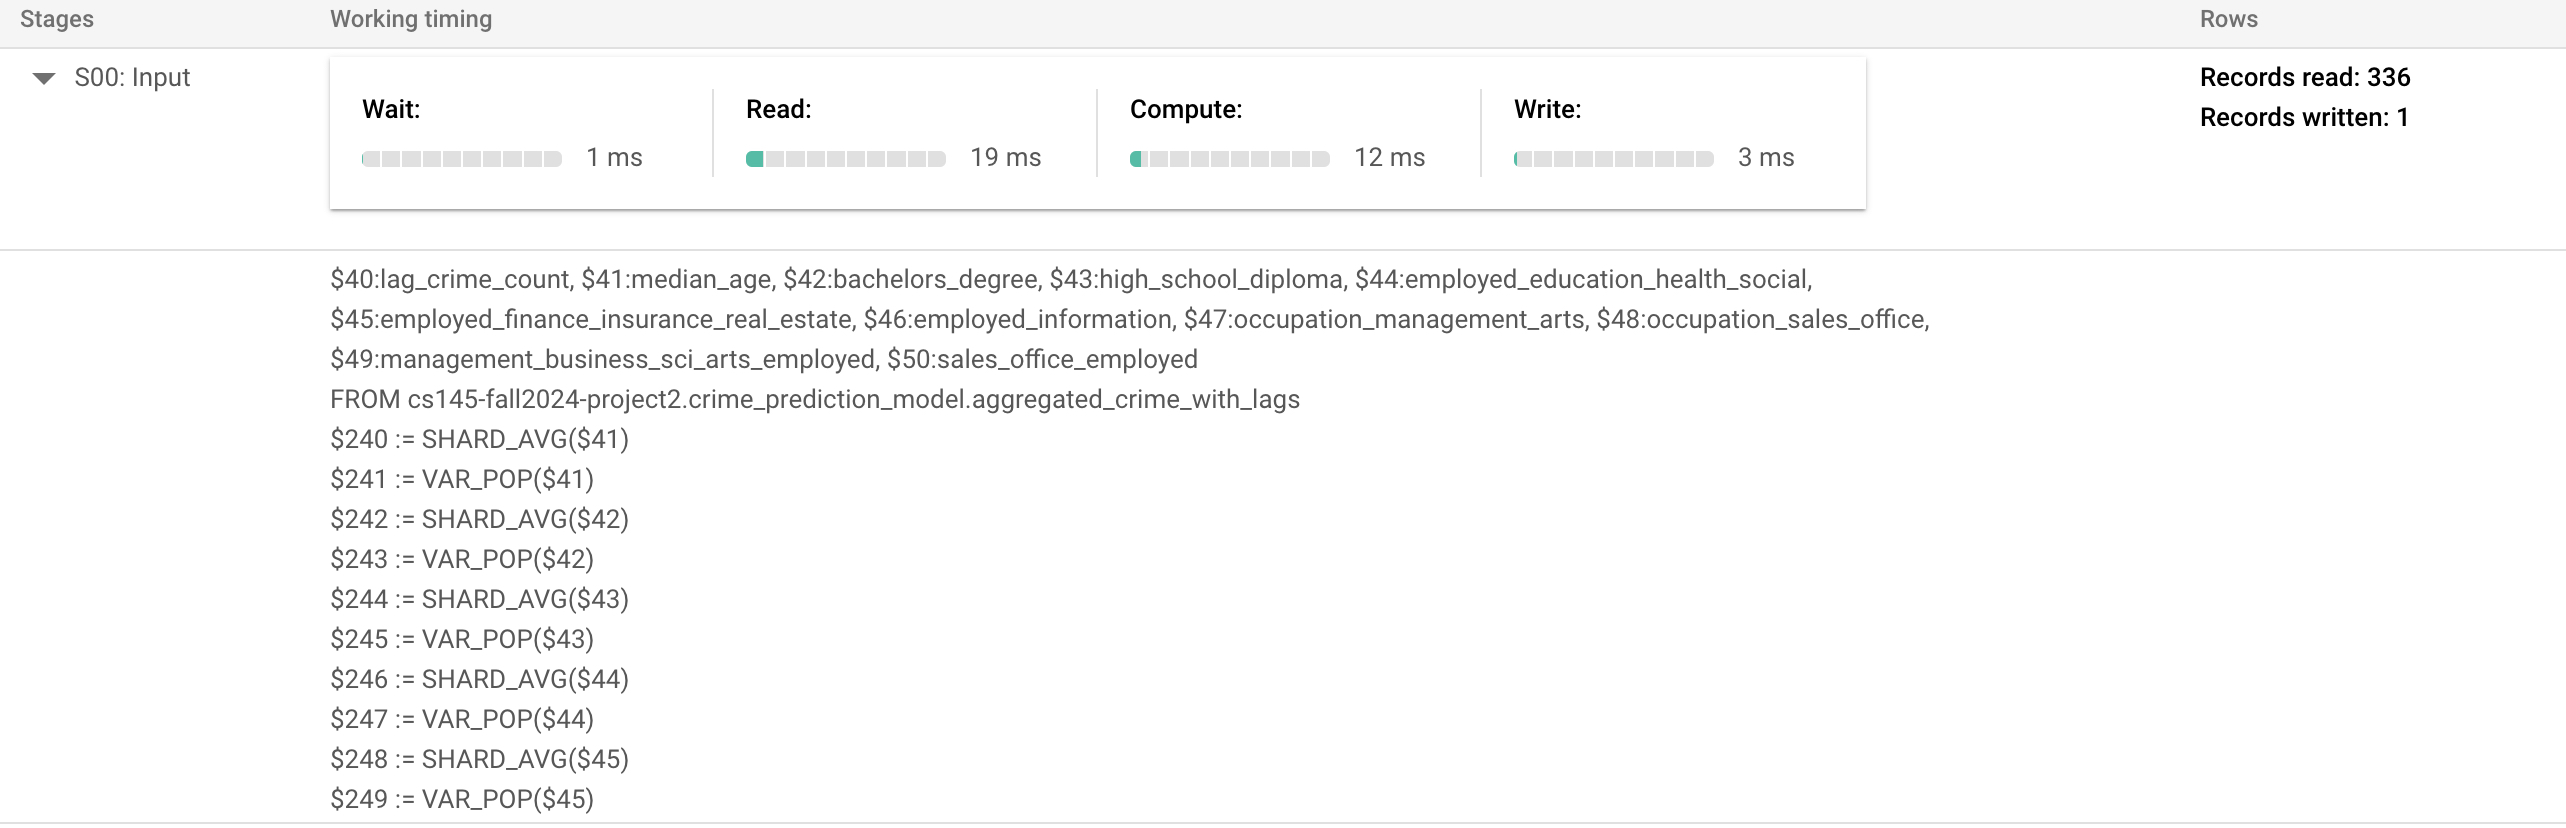

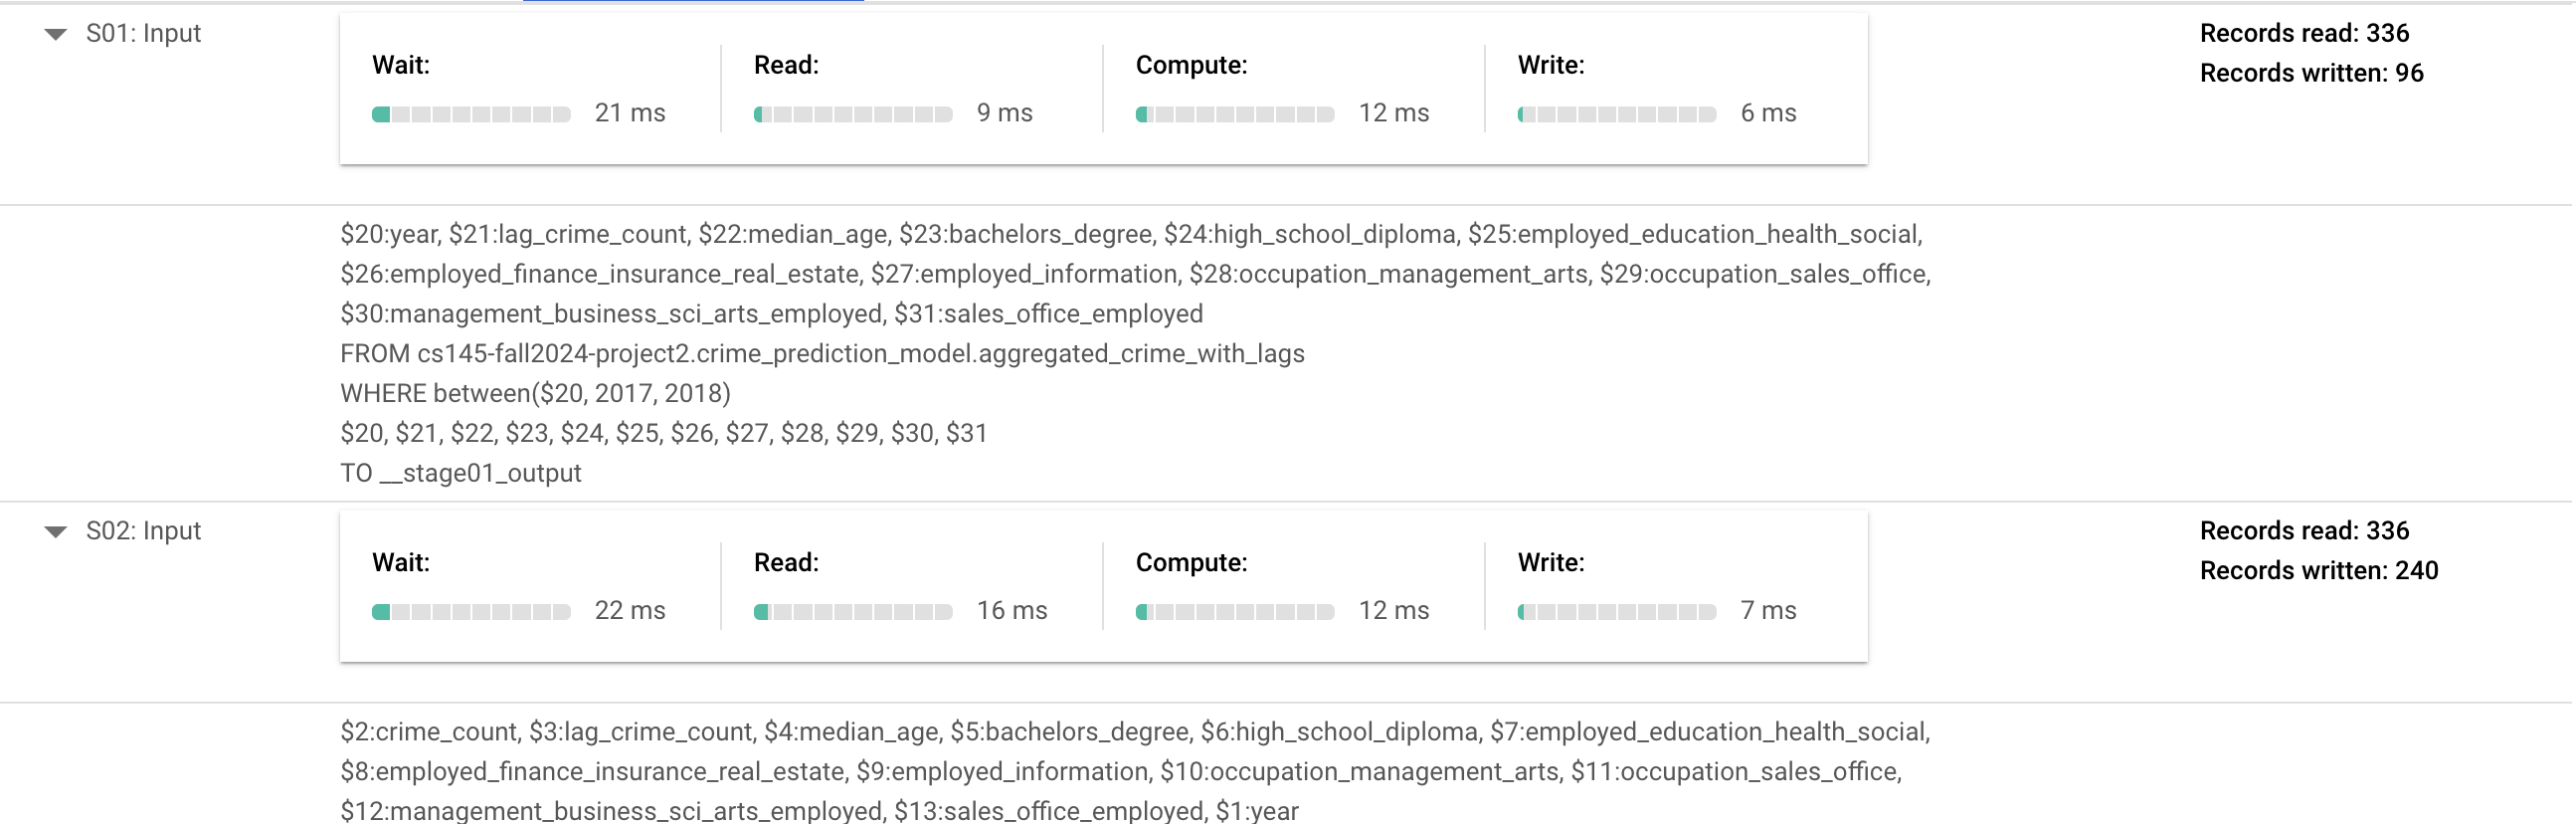

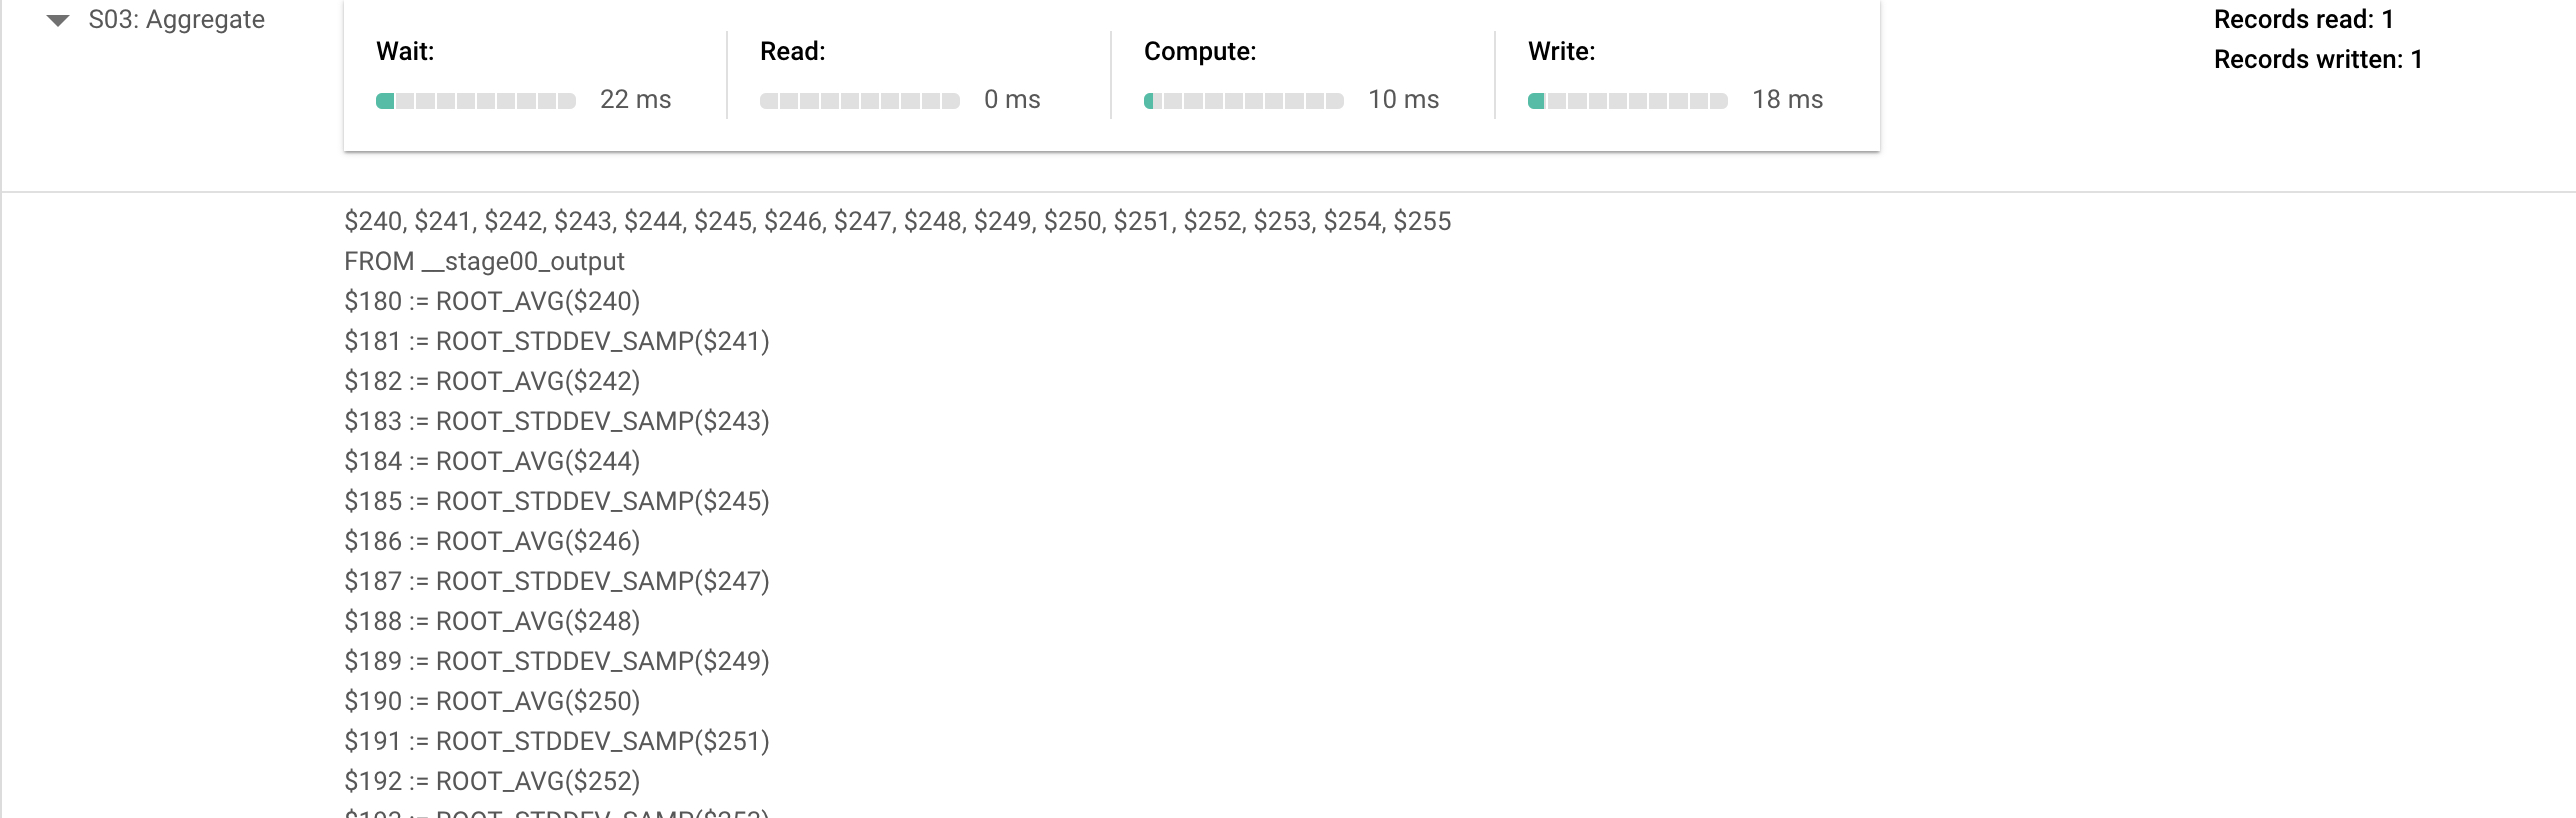

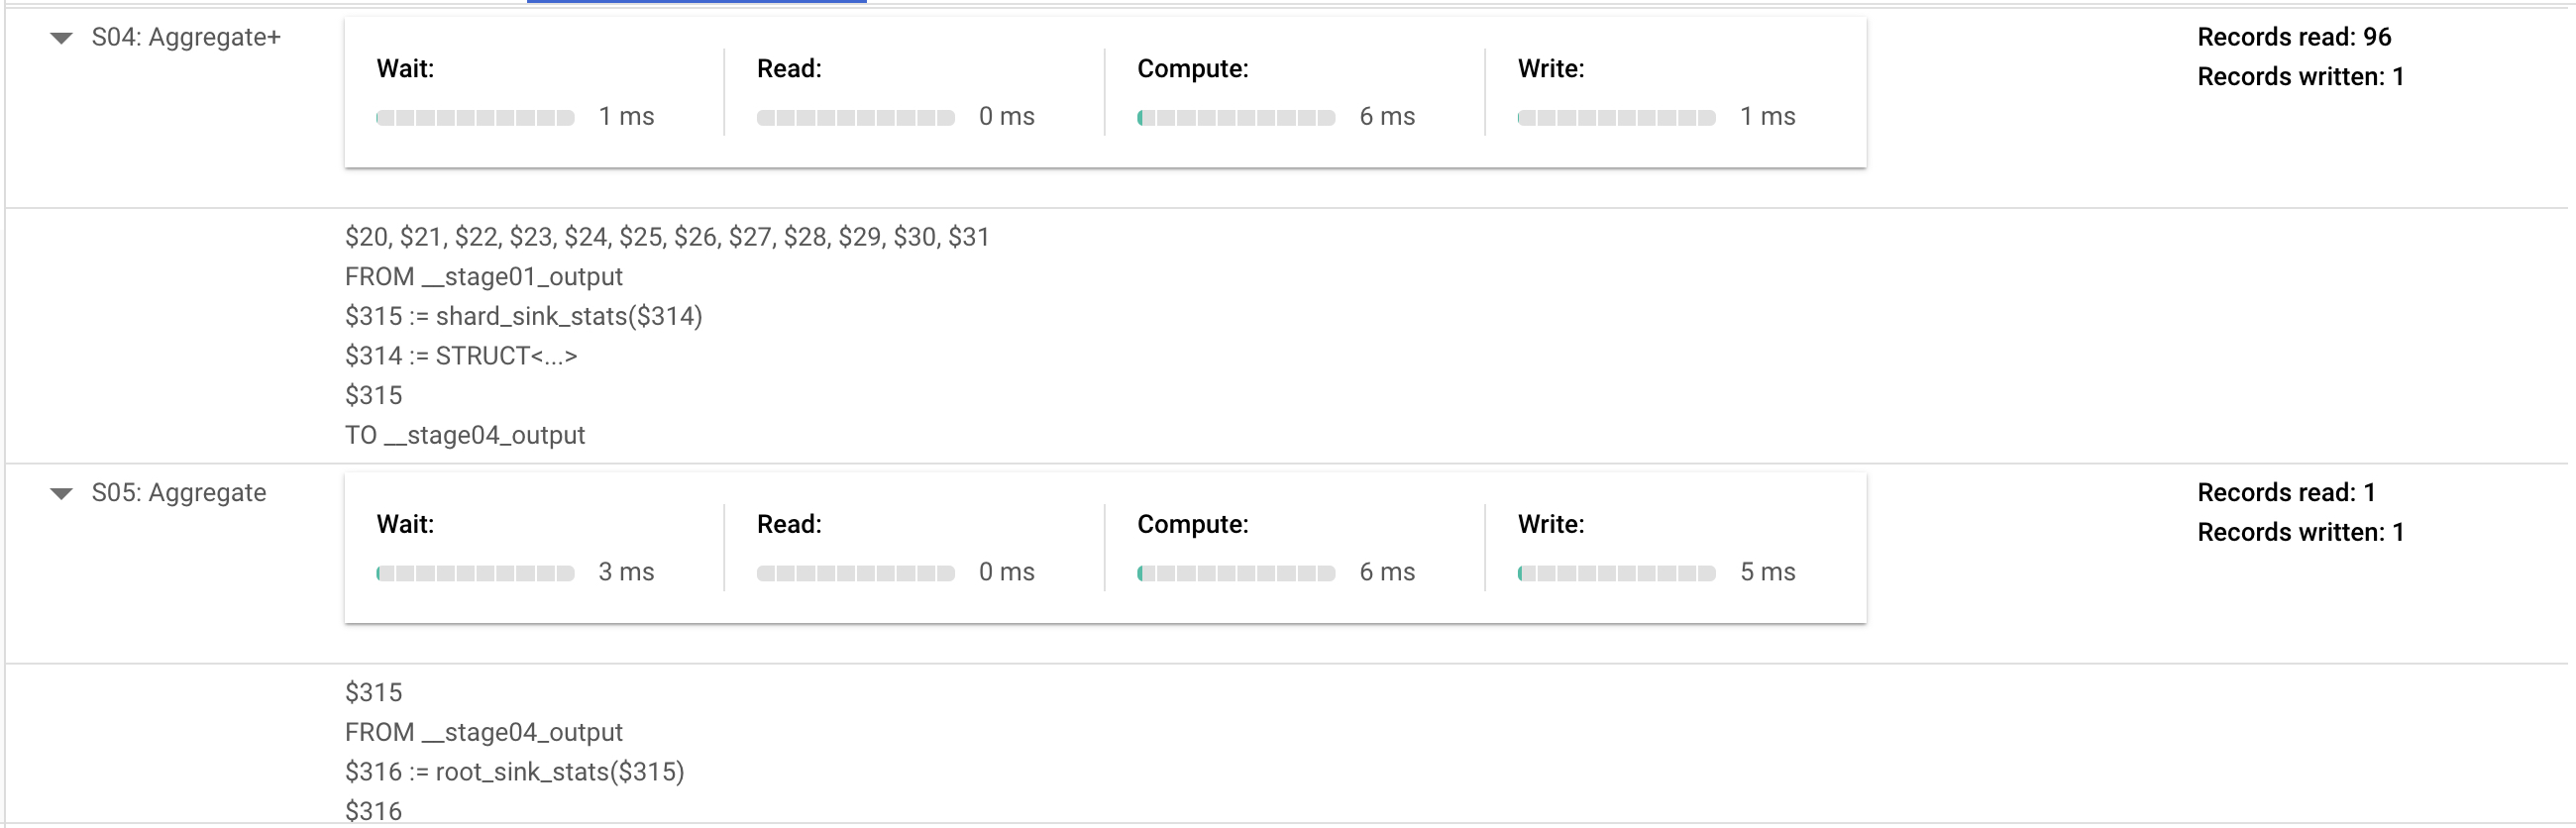

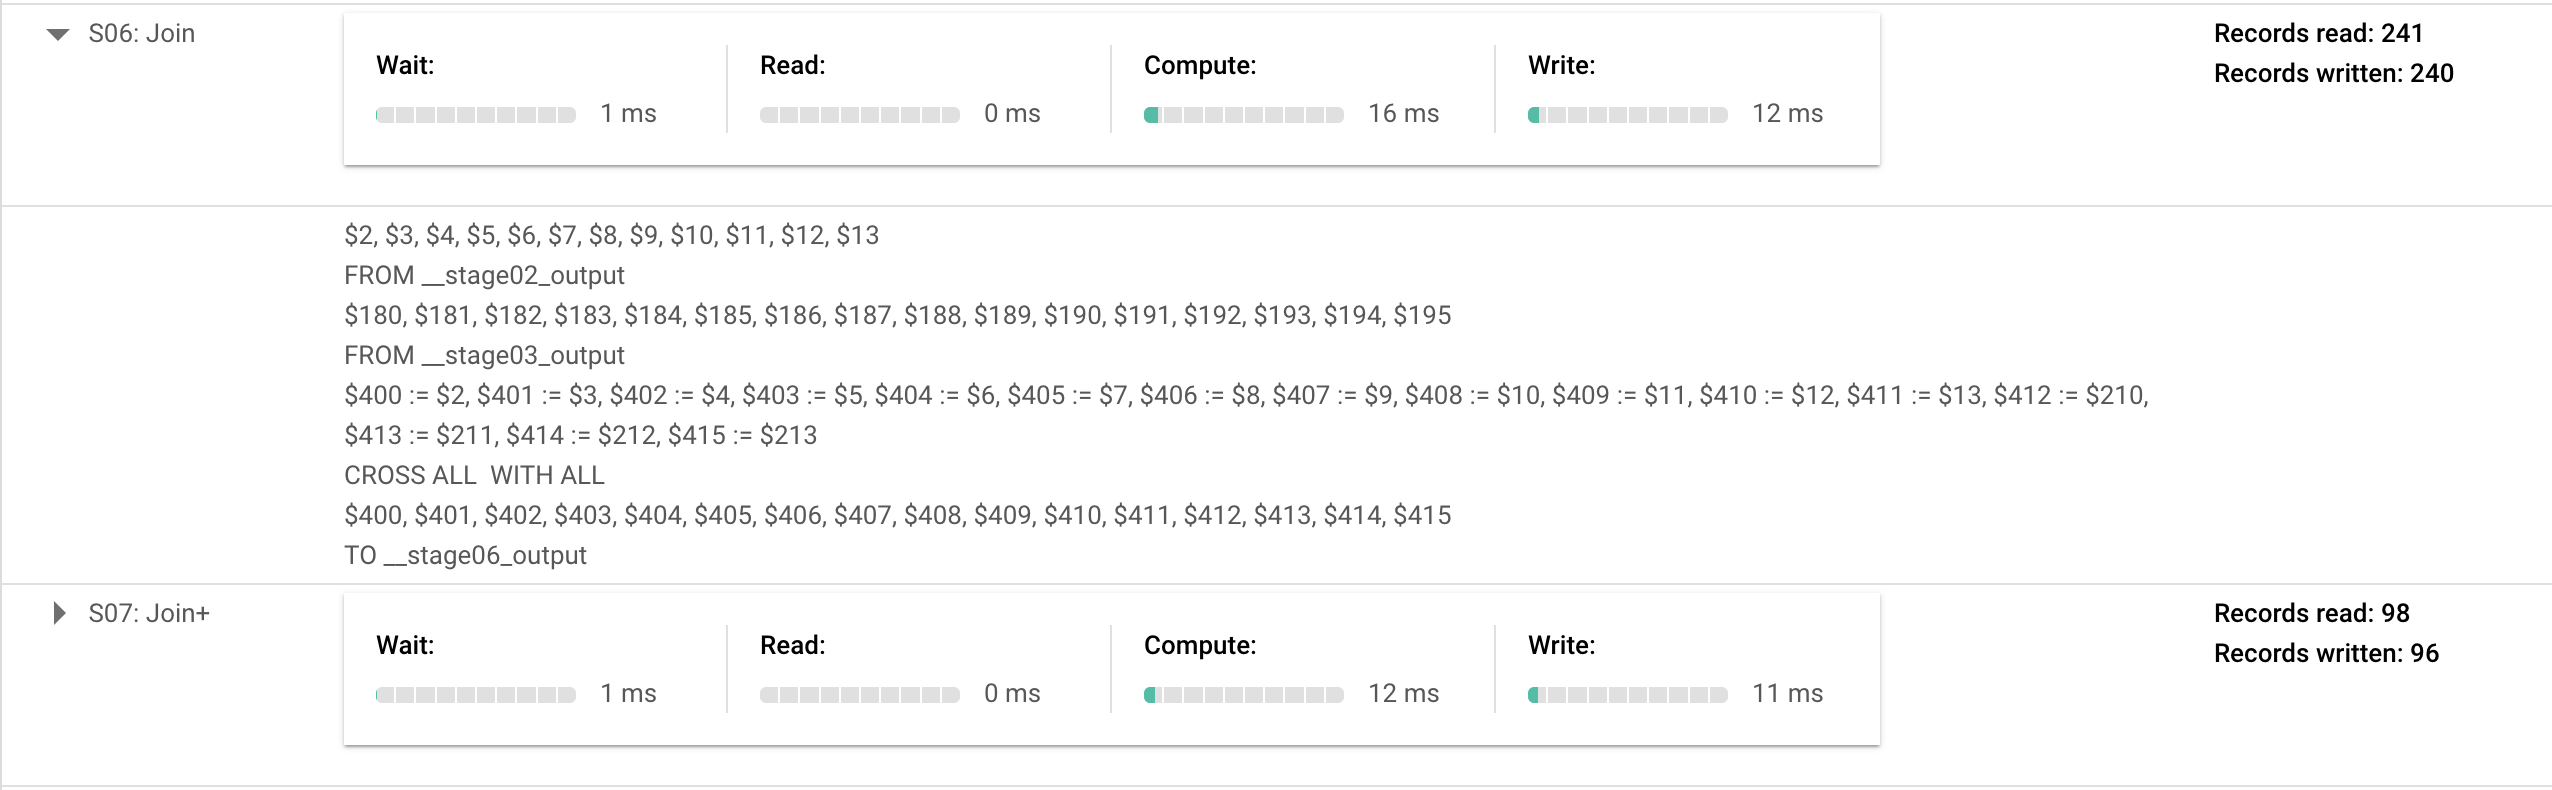

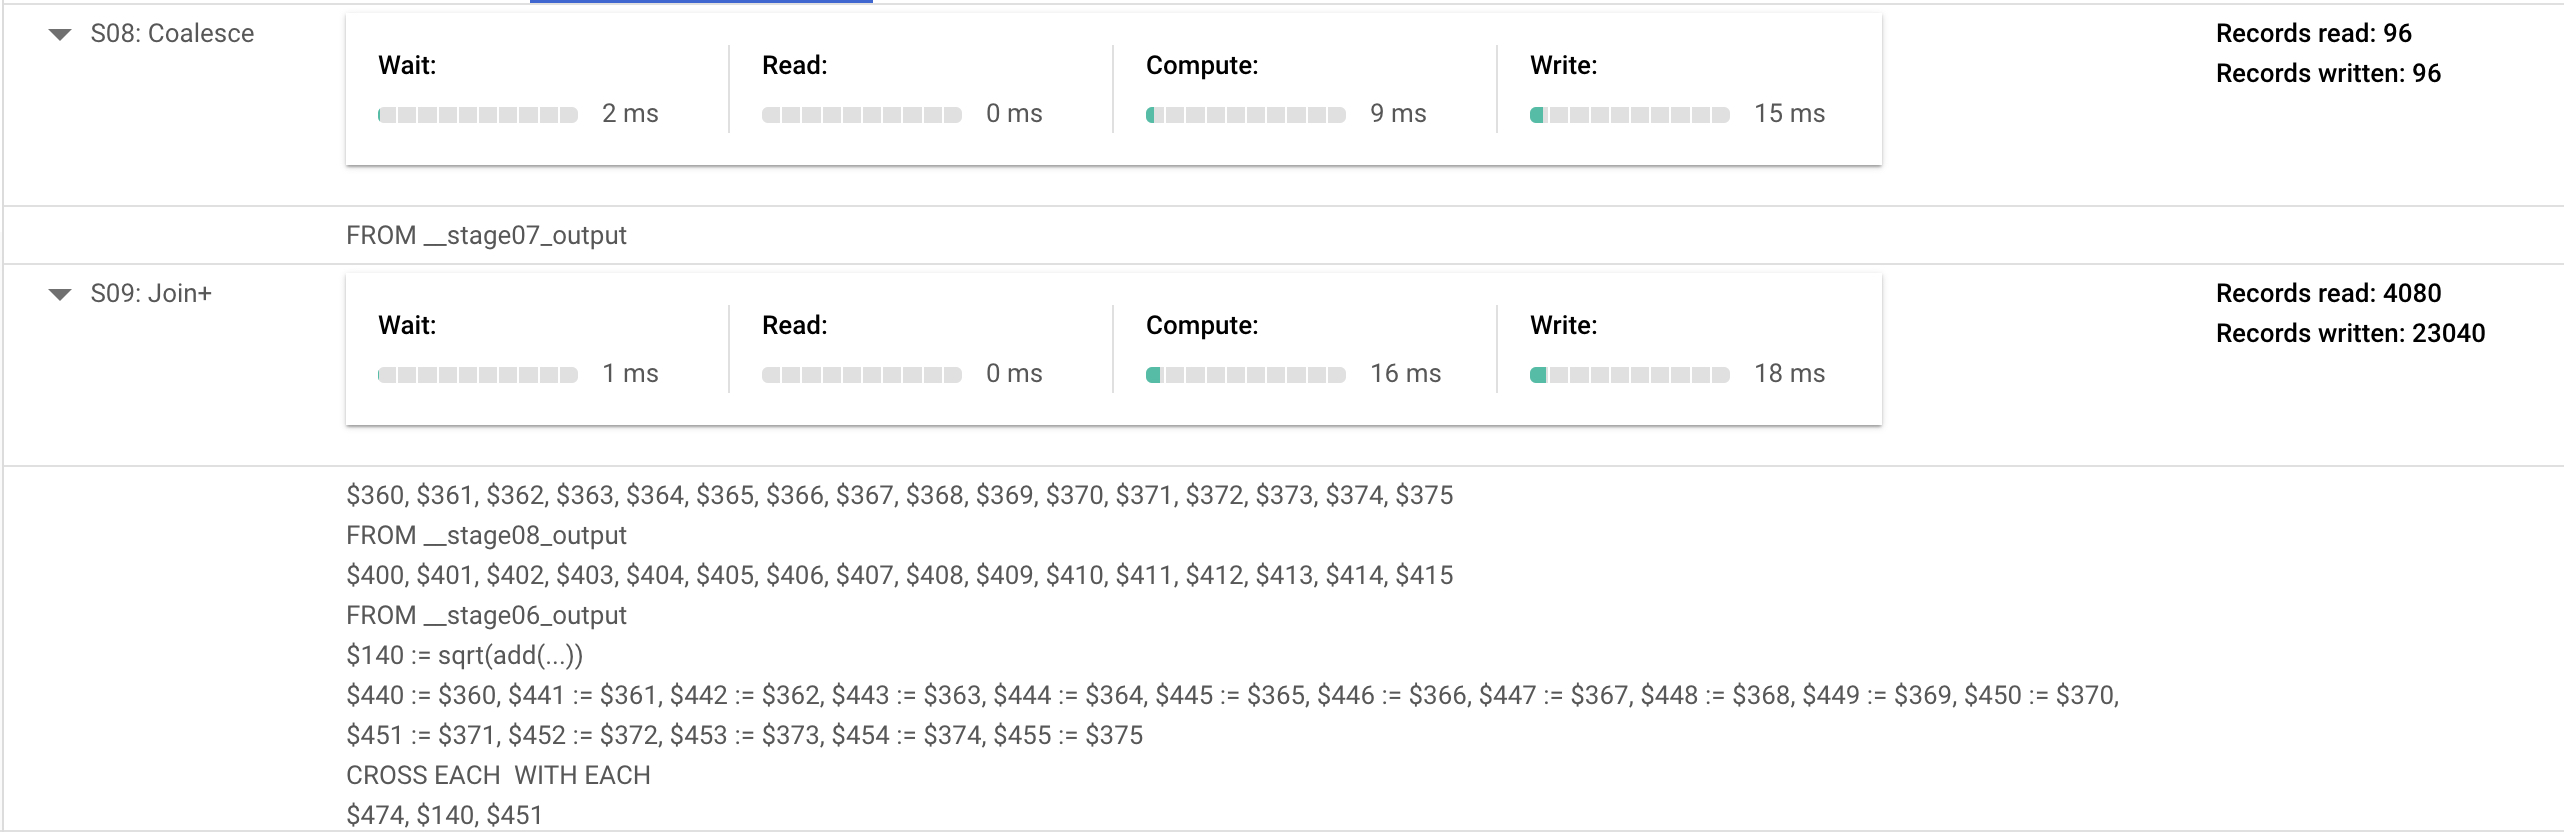

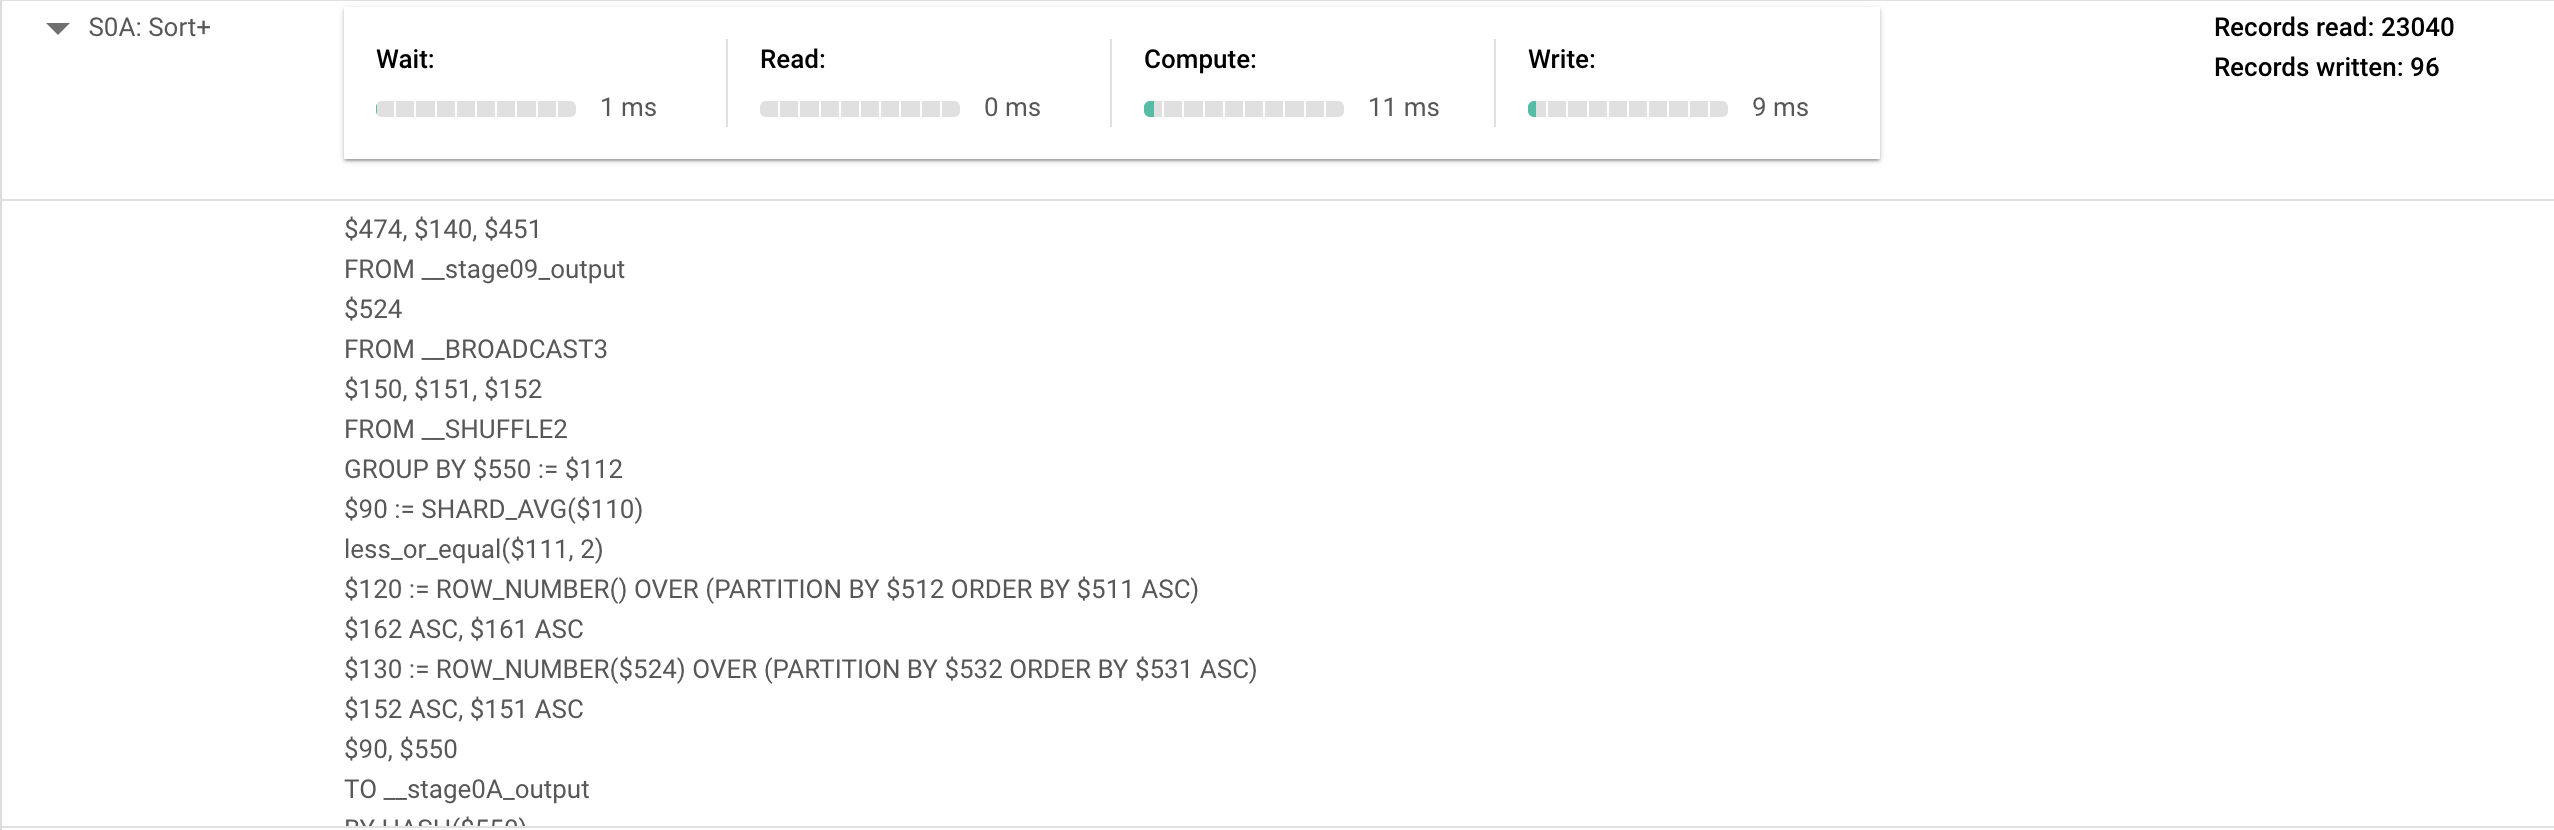

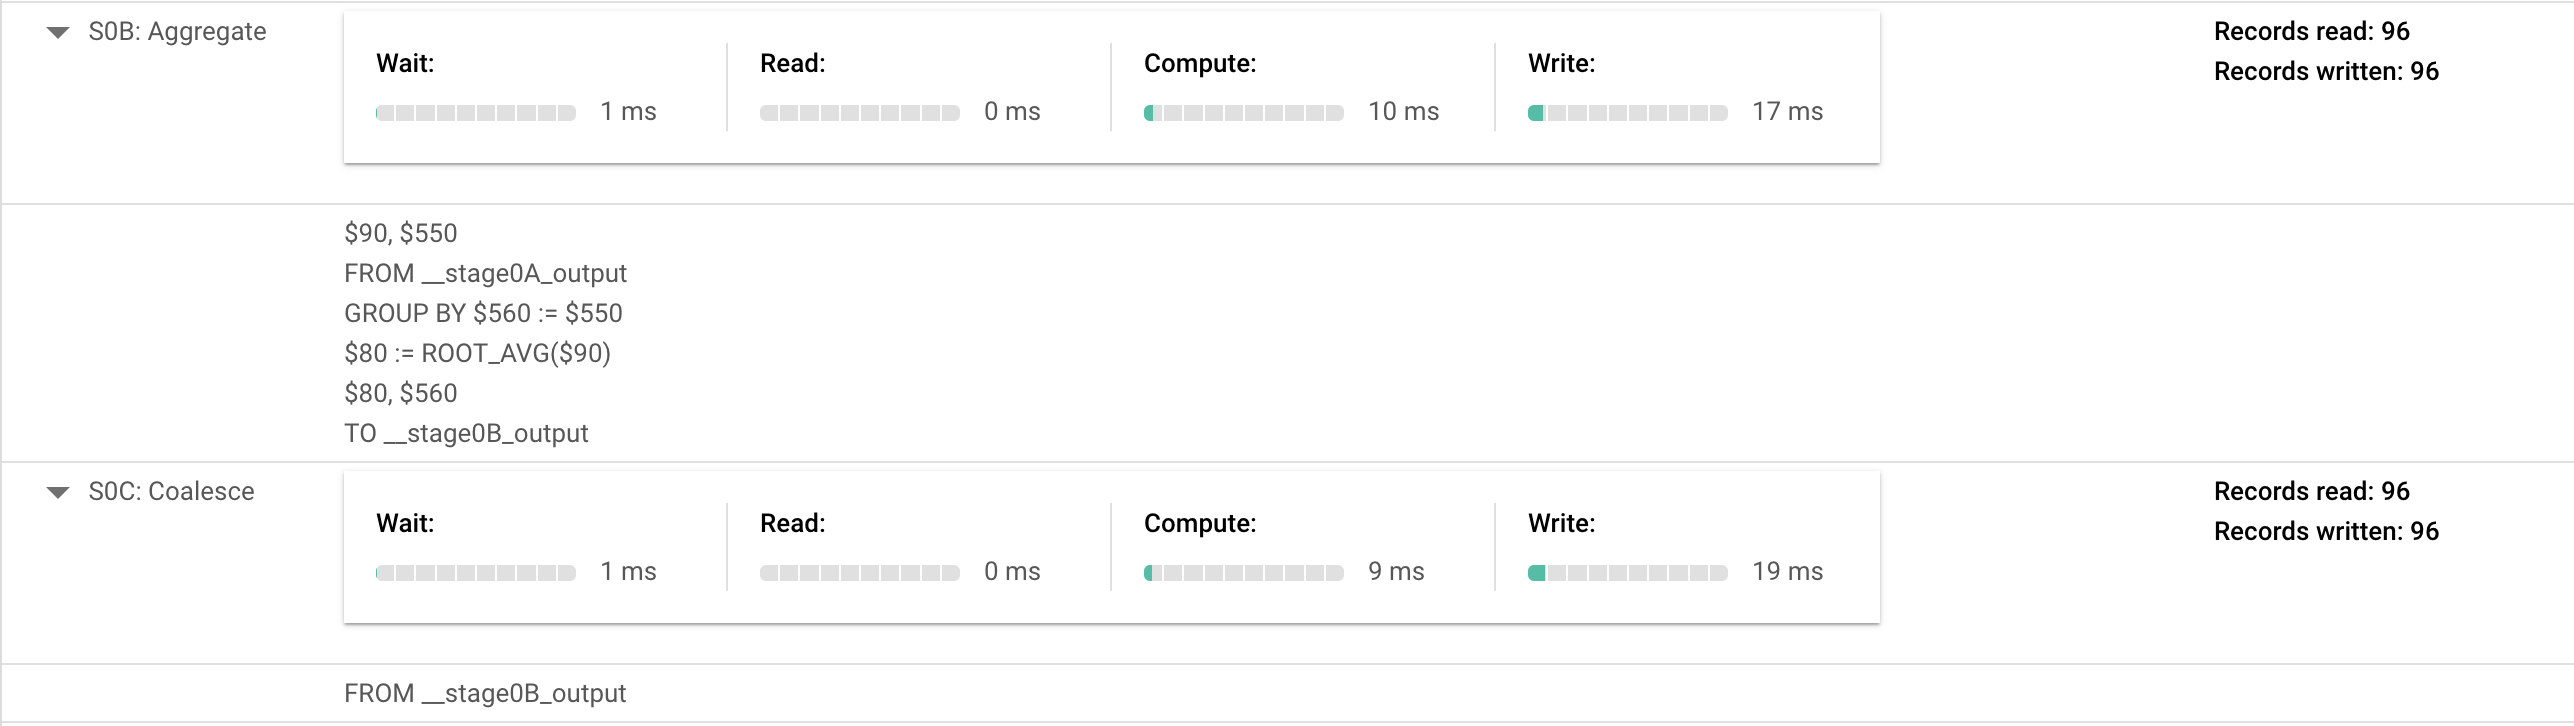

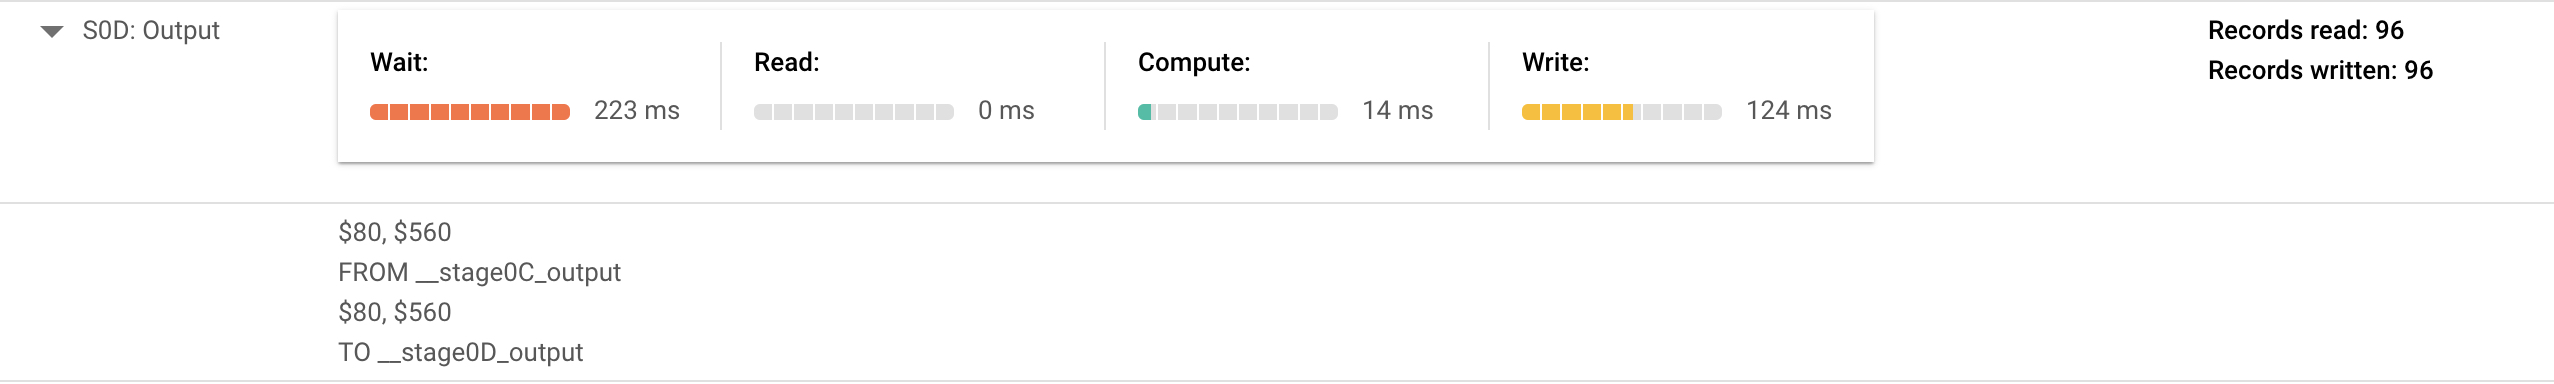

We will proceed by thinking about the IO complexity by the CTEs.

For the training CTE, we notice that every row of the original table is read, and only those that are between the years 2011 and 2016 are written. Therefore, the cost for this step is C_r * P(Crime Table) + C_w * N, where N = P(Crime Table WHERE YEAR BETWEEN 2011 AND 2016). Then, it must sort the years column in ascending order in order to create an id column. This part has an the IO cost of BigSort(Crime Table WHERE YEAR BETWEEN 2011 AND 2016) = (C_r + C_w) * N * (1 + ⌈log_B N/(2B)⌉).

The IO cost for the test CTE is similar to the training CTE. For the filtering step: C_r * P(Crime Table) + C_w * M, where M = P(Crime WHERE YEAR BETWEEN 2017 AND 2018). The sorting step: BigSort(Crime WHERE YEAR BETWEEN 2017 AND 2018) = (C_r + C_w) * M * (1 + ⌈log_B M/(2B)⌉).

The feature_stats CTE is very simple. It simply reads all the rows in the Crime table and writes the computed values in a single row. We therefore have that the IO cost is C_r * P(Crime Table) + C_w.

The normalized_training CTE has a cross join between the training table and the feature_stats table. The training table has 240 rows and the feature_stats table has 1 row. This operation has an IO cost of BNLJ(training, feature_stats) = C_r * (P(training) + P(feature_stats) * ⌈P(training) / B⌉) + C_w * OUT.

Then, it must write the computed values for each row. Therefore, the cost at this step is (C_r + C_w) * P(Cross Join Table between training and feature_stats tables).

The normalized_test CTE has a similar cost to the normalized_training CTE. The Cross Join step: BNLJ(test, feature_stats) = C_r * (P(test) + P(feature_stats) * ⌈P(test) / B⌉) + C_w * OUT. The computed values step: (C_r + C_w) * P(Cross Join Table between test and feature_stats tables).

The distances CTE does a cross join operation between the normalized_test and normalized_training tables. It then computed the distance for each row. The IO cost of the cross join operation is BNLJ(normalized_test, normalized_training) = C_r * (P(normalized_test) + P(normalized_training) * ⌈P(normalized_test) / B⌉) + C_w * OUT.

The IO cost of computing the distances for each row is (C_r + C_w) * P(Cross Join Table between normalized_test and normalized_training tables).

The ranked_distances CTE adds a rank column to the distances CTE. It does this by partitioning by test_id and ordering the rank by distance asc. The IO cost of the partitioning step is HashPartition(Distances) = (C_r + C_w) * P(Distances). We will set N to be equal to the number of rows or TestIds (96). The IO cost of the sorting step is Sigma to the N of BigSort(Nth Partition) (with an index of i starting at 1), where BigSort(ith Partition) = (C_r + C_w) * P(ith Partition) * (1 + ⌈log_B P(ith Partition)/(2B)⌉).

The predictions CTE filters the ranked_distances CTE where the rank is less than or equal to 2. It then groups by test_id and computes the average of train_crime_count. The IO cost of the filtering step is C_r * P(ranked_distances) + C_w * P(ranked_distances where rank <= 2). The IO cost of the groupby part is HashPartition(ranked_distances where rank <= 2) = (C_r + C_w) * P(ranked_distances where rank <= 2) . The IO cost of computing the average of train_crime_count is C_r * P(ranked_distances where rank <= 2) + C_w * P(predictions), where P(predictions) is equal to the number of test_ids (96).

The total cost is the following:

C_r * P(Crime Table) + C_w * N, where N = P(Crime Table WHERE YEAR BETWEEN 2011 AND 2016)

BigSort(Crime Table WHERE YEAR BETWEEN 2011 AND 2016) = (C_r + C_w) * N * (1 + ⌈log_B N/(2B)⌉)

C_r * P(Crime Table) + C_w * M, where M = P(Crime WHERE YEAR BETWEEN 2017 AND 2018)

BigSort(Crime WHERE YEAR BETWEEN 2017 AND 2018) = (C_r + C_w) * M * (1 + ⌈log_B M/(2B)⌉)

C_r * P(Crime Table) + C_w

BNLJ(training, feature_stats) = C_r * (P(training) + P(feature_stats) * ⌈P(training) / B⌉) + C_w * OUT



## Section 4: Conclusion (5 points)

Please answer the following questions below -- feel free to add any other insights or conclusions drawn from implementing the KNN baseline:

1. How does KNN compare to running one of BigQuery's ML models (linear regression or logistic regression)? Was it more powerful, or less complex to implement?

The KNN model runs better than the BigQuery ML model whether it be logistic regression or linear regression. In the case of our project 2, we utilized a linear regression model and proceeded to us the random tree forest regression. This change was due to the lack of a obvious linear relationship between the various predictors of the training observations. As such, we chose this model type because it is better suited to regress on non-linear data while accurately approximating the true value of the response value (crime_count).

Given that the KNN model relies on simple euclidean distance calculations, the KNN model can be said to be less complex to implement than the logistic, linear, or random forest tree regression models. This is also indicated by the fact that the KNN model only took 1 sec to run where as the random forest tree regression or linear regression took a couple of minutes. This is in spite of both models working with preprocessed data.Furthermore, given that the error metrics indicate that the KNN is more accurate, it can be said that KNN is also more powerful.

2. Did you learn anything new about your data or central questions from running the KNN baseline?

I learned that predictions of the models are more accurately calculated when normalizing all of the numerical data as it avoids noise from being captured in predictions as some predictors may have a significantly larger weight on the models due to their scale, i.e. bachelors_degree feature.

In terms of the central questions, this model, KNN, reinforces what we learned from the other models given that the MSE is only marginally lower than the random forest tree regressor.
